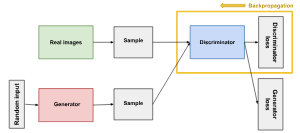

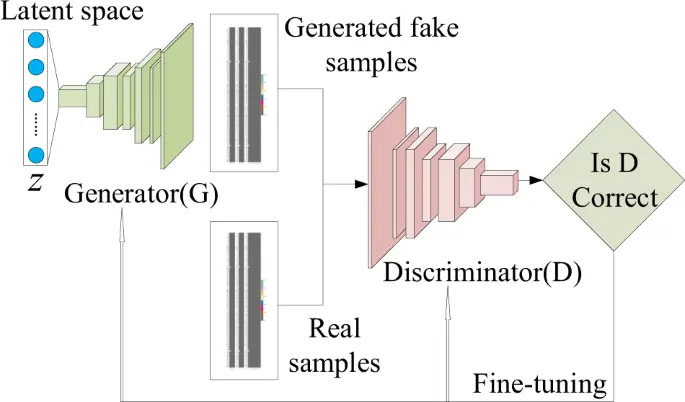

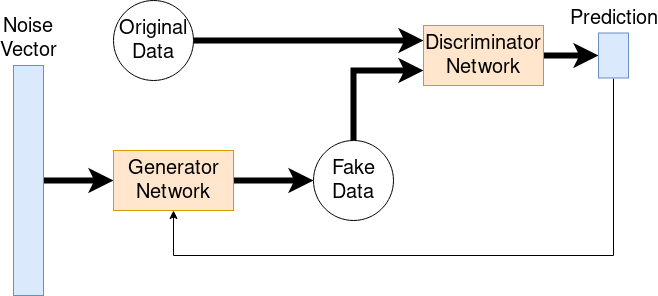

In [1]:
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Dropout
from tensorflow.keras.layers import BatchNormalization, Activation, LeakyReLU, UpSampling2D, Conv2D
from tensorflow.keras.models import Sequential, Model

import numpy as np
import matplotlib.pyplot as plt

In [2]:
import os
if not os.path.exists("./data/gan_images"):
    os.makedirs("./data/gan_images")

In [3]:
# 생성자 모델을 만듭니다.
generator = Sequential()
generator.add(Dense(128*7*7, input_dim=100, activation=LeakyReLU(0.2)))
generator.add(BatchNormalization())
generator.add(Reshape((7, 7, 128)))
generator.add(UpSampling2D())
generator.add(Conv2D(64, kernel_size=5, padding='same'))
generator.add(BatchNormalization())
generator.add(Activation(LeakyReLU(0.2)))
generator.add(UpSampling2D())
generator.add(Conv2D(1, kernel_size=5, padding='same', activation='tanh'))

In [9]:
generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 6272)              633472    
                                                                 
 batch_normalization (Batch  (None, 6272)              25088     
 Normalization)                                                  
                                                                 
 reshape (Reshape)           (None, 7, 7, 128)         0         
                                                                 
 up_sampling2d (UpSampling2  (None, 14, 14, 128)       0         
 D)                                                              
                                                                 
 conv2d (Conv2D)             (None, 14, 14, 64)        204864    
                                                                 
 batch_normalization_1 (Bat  (None, 14, 14, 64)        2

In [4]:
# 판별자 모델을 만듭니다.
discriminator = Sequential()
discriminator.add(Conv2D(64, kernel_size=5,
                         strides=2, # 필터가 입력 데이터를 스캔할 때 얼마나 많이 이동하는지 나타낸낟
                                    # 필터는 2칸씩 이동하면서 연산을 수행한다
                                    # 스트라이드가 커질수록 출력 크기가 작아져 피처 맵의 크기를 조절
                         input_shape=(28,28,1),
                         padding="same"))
discriminator.add(Activation(LeakyReLU(0.2)))
discriminator.add(Dropout(0.3))
discriminator.add(Conv2D(128, kernel_size=5, strides=2, padding="same"))
discriminator.add(Activation(LeakyReLU(0.2)))
discriminator.add(Dropout(0.3))
discriminator.add(Flatten())
discriminator.add(Dense(1, activation='sigmoid'))
discriminator.compile(loss='binary_crossentropy', optimizer='adam')
discriminator.trainable = False
# **판별자(Discriminator)**의 가중치가 **동결(Freeze)**되어,
# 생성자(Generator)와의 학습 과정에서 판별자의 가중치가 업데이트되지 않도록 합니다.

# 생성자를 학습할 때, 판별자의 가중치는 고정되고,
# 오직 생성자의 가중치만 업데이트됩니다.
# 이는 GAN이 생성과 판별의 상호작용을 통해 학습하기 때문입니다.

>Conv2D (2D Convolutional Layer)

역할: 입력 데이터(이미지)에 2D 컨벌루션 연산을 수행하여 특징 맵을 추출함.

설명: 이미지의 공간적 특징(에지, 텍스처 등)을 추출하는 역할을 하며, 필터(커널)를 사용해 입력 이미지에서 특징 맵을 생성함.

파라미터:

필터 수: 생성할 특징 맵의 수.

필터 크기: 예: (3, 3) 크기의 필터.

스트라이드: 필터가 입력 데이터 위에서 이동하는 간격.

패딩: 입력 데이터의 경계를 어떻게 처리할지 결정함.

>Dropout

역할: 학습 중에 일부 뉴런을 무작위로 비활성화하여 과적합을 방지함.

설명: 뉴런의 출력값을 0으로 만들어 학습 과정에서 특정 뉴런에 의존하는 현상을 줄이고, 모델의 일반화 성능을 향상시킴.

파라미터:

비율: 드롭아웃할 뉴런의 비율(예: Dropout(0.5)는 50%의 뉴런을 비활성화).

>Flatten

역할: 다차원 배열(예: 이미지)을 1차원 벡터로 변환함.

설명: Conv2D 층에서 추출된 2D 특징 맵을 Dense 층에 전달하기 위해 데이터를 평탄화함.

파라미터: 없음 (단순히 데이터 형태를 변환하는 층).

In [10]:
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 14, 14, 64)        1664      
                                                                 
 activation_1 (Activation)   (None, 14, 14, 64)        0         
                                                                 
 dropout (Dropout)           (None, 14, 14, 64)        0         
                                                                 
 conv2d_3 (Conv2D)           (None, 7, 7, 128)         204928    
                                                                 
 activation_2 (Activation)   (None, 7, 7, 128)         0         
                                                                 
 dropout_1 (Dropout)         (None, 7, 7, 128)         0         
                                                                 
 flatten (Flatten)           (None, 6272)             

In [5]:
# 생성자와 판별자 모델을 연결시키는 gan 모델을 만듭니다.
ginput = Input(shape=(100,))
# 생성자의 입력층을 정의
dis_output = discriminator(generator(ginput))
# 생성자와 판별자를 연결하여 전체 간의 출력을 정의
gan = Model(ginput, dis_output)
# 간 모델 생성
gan.compile(loss='binary_crossentropy', optimizer='adam')
# 컴파일 과정: 생성자의 학습, 가짜 데이터를 진짜처럼 보이게 만들기 위해 자신의 가중치 업데이트
gan.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100)]             0         
                                                                 
 sequential (Sequential)     (None, 28, 28, 1)         865281    
                                                                 
 sequential_1 (Sequential)   (None, 1)                 212865    
                                                                 
Total params: 1078146 (4.11 MB)
Trainable params: 852609 (3.25 MB)
Non-trainable params: 225537 (881.00 KB)
_________________________________________________________________


1/1 [==============================] - 0s 105ms/step
epoch:0  d_loss:0.6959  g_loss:0.4849
1/1 [==============================] - 0s 28ms/step
epoch:1  d_loss:0.4874  g_loss:0.1778
1/1 [==============================] - 0s 24ms/step
epoch:2  d_loss:0.4832  g_loss:0.0487
1/1 [==============================] - 0s 24ms/step
epoch:3  d_loss:0.5230  g_loss:0.0329
1/1 [==============================] - 0s 25ms/step
epoch:4  d_loss:0.5211  g_loss:0.0630
1/1 [==============================] - 0s 24ms/step
epoch:5  d_loss:0.4915  g_loss:0.1641
1/1 [==============================] - 0s 29ms/step
epoch:6  d_loss:0.4654  g_loss:0.3468
1/1 [==============================] - 0s 28ms/step
epoch:7  d_loss:0.4630  g_loss:0.5255
1/1 [==============================] - 0s 25ms/step
epoch:8  d_loss:0.4578  g_loss:0.6572
1/1 [==============================] - 0s 26ms/step
epoch:9  d_loss:0.4312  g_loss:0.7216
1/1 [==============================] - 0s 23ms/step
epoch:10  d_loss:0.4262  g_loss:0.7508
1/1 [===

KeyboardInterrupt: 

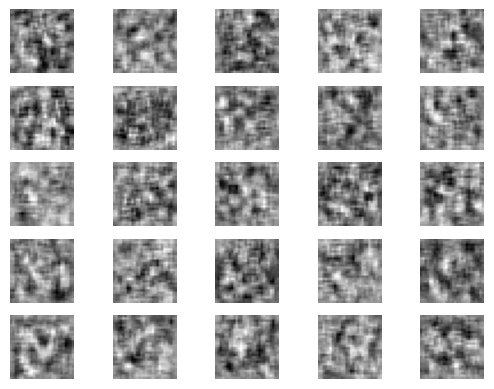

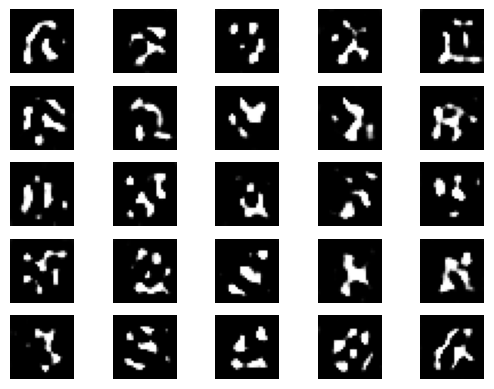

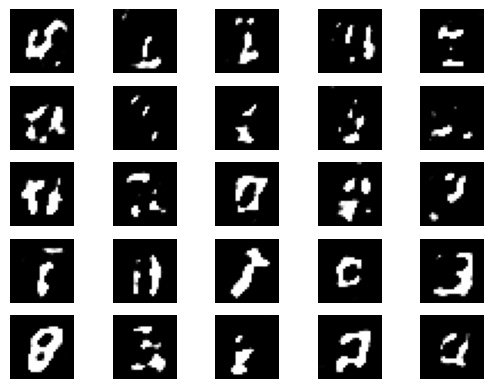

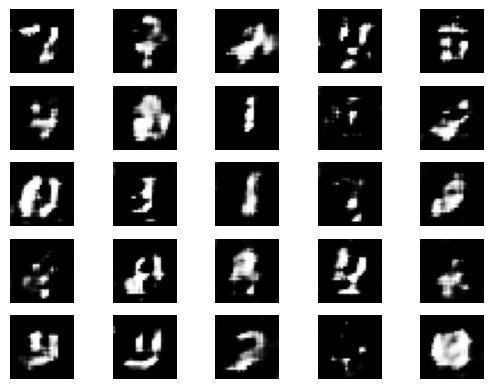

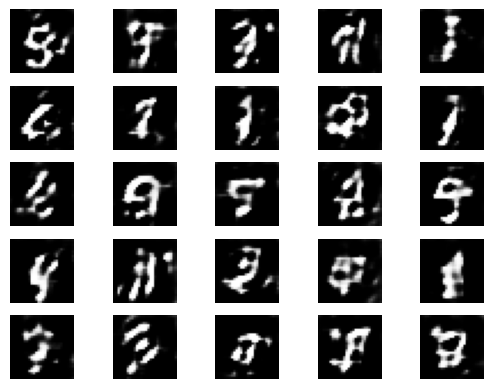

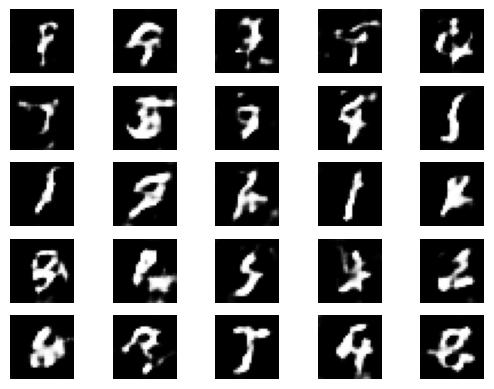

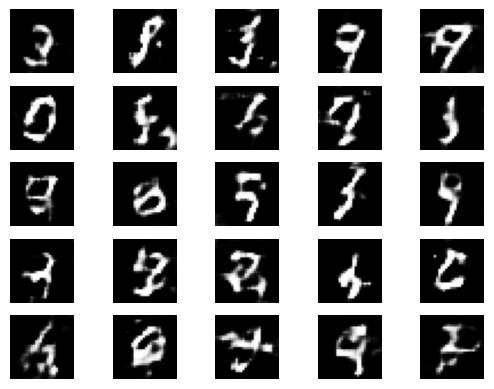

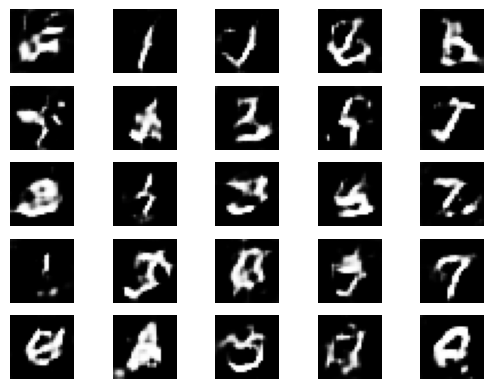

In [6]:
# 신경망을 실행시키는 함수를 만듭니다.
def gan_train(epoch, batch_size, saving_interval):

  # MNIST 데이터를 불러옵니다.

  (X_train, _), (_, _) = mnist.load_data()  # 앞서 불러온 적 있는 MNIST를 다시 이용합니다.
  # 단, 테스트 과정은 필요 없고 이미지만 사용할 것이기 때문에 X_train만 불러왔습니다.
  X_train = X_train.reshape(X_train.shape[0], 28, 28, 1).astype('float32')
  X_train = (X_train - 127.5) / 127.5  # 픽셀 값은 0에서 255 사이의 값입니다.
  # 이전에 255로 나누어 줄때는 이를 0~1 사이의 값으로 바꾸었던 것인데,
  # 여기서는 127.5를 빼준 뒤 127.5로 나누어 줌으로 인해 -1에서 1사이의 값으로 바뀌게 됩니다.
  # X_train.shape, Y_train.shape, X_test.shape, Y_test.shape

  true = np.ones((batch_size, 1))
  fake = np.zeros((batch_size, 1))

  for i in range(epoch):
          # 실제 데이터를 판별자에 입력하는 부분입니다.
          idx = np.random.randint(0, X_train.shape[0], batch_size)
          imgs = X_train[idx]
          d_loss_real = discriminator.train_on_batch(imgs, true)

          # 가상 이미지를 판별자에 입력하는 부분입니다.
          noise = np.random.normal(0, 1, (batch_size, 100))
          gen_imgs = generator.predict(noise)
          d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)

          # 판별자와 생성자의 오차를 계산합니다.
          d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
          g_loss = gan.train_on_batch(noise, true)

          print('epoch:%d' % i, ' d_loss:%.4f' % d_loss, ' g_loss:%.4f' % g_loss)

        # 이 부분은 중간 과정을 이미지로 저장해 주는 부분입니다.
        # 본 장의 주요 내용과 관련이 없어
        # 소스 코드만 첨부합니다.
        # 만들어진 이미지들은 gan_images 폴더에 저장됩니다.
          if i % saving_interval == 0:
              #r, c = 5, 5
              noise = np.random.normal(0, 1, (25, 100))
              gen_imgs = generator.predict(noise)

              # Rescale images 0 - 1
              gen_imgs = 0.5 * gen_imgs + 0.5

              fig, axs = plt.subplots(5, 5)
              count = 0
              for j in range(5):
                  for k in range(5):
                      axs[j, k].imshow(gen_imgs[count, :, :, 0], cmap='gray')
                      axs[j, k].axis('off')
                      count += 1
              fig.savefig("./data/gan_images/gan_mnist_%d.png" % i)

gan_train(2001, 32, 200)  # 2000번 반복되고,
# 배치 사이즈는 32,  200번마다 결과가 저장되게 하였습니다.